# 支持向量机（SVM）和SMO算法
找到具有最小间隔的数据点，再对该间隔最大化：
$$
\mathop{\arg\max}_{(w,b)}\{\min_n \ label·\frac{(w^Tx+b)}{||w||}\}
$$
转化后的优化目标函数：
$$
\begin{align}
\max_\alpha[\sum_{i=1}^m\alpha-\frac{1}{2}\sum_{i,j=1}^{m}&label^{(i)}·label^{(j)}·\alpha_i·\alpha_j·<x^{(i)},x^{(j)}>] \\\\
st. \ &\alpha\geq0\\
&\sum_{i-1}^m\alpha_i·label^{(i)}=0
\end{align}
$$
引入松弛变量后约束条件变为：
$$
\begin{align}
st. \ &C\geq\alpha\geq0\\&\sum_{i-1}^m\alpha_i·label^{(i)}=0
\end{align}
$$

## SMO：序列最小优化（Sequential Minimal Optimization）
将大优化问题分解为多个小优化问题  
SMO目标：求出一系列$\alpha$和$b$，然后可以容易计算出$w$  
工作原理：  
1.每次循环选择两个$\alpha$进行优化处理  
2.一旦找到一对“合适”的$\alpha$，就一个增大一个减小 

In [2]:
import numpy as np
from numpy import *
from time import sleep
import matplotlib.pyplot as plt
%matplotlib inline

In [69]:
# 读取数据，获得特征与标签
def loadDataSet(fileName):
    """
    读取数据集
    参数：
        fileName -- 文件名
    返回：
        dataMat -- 数据矩阵
        label -- 标签矩阵
    """
    dataMat = []; labelMat = []                                      #新建数据和标签矩阵列表                                          
    with open(fileName) as fr:                                              #新建数据和标签矩阵列表
        for line in fr.readlines():                                      #一行行读取      
            lineArr = line.strip().split('\t')                           #以制表符分割        
            dataMat.append([np.float(lineArr[0]), np.float(lineArr[1])]) #数据第1、2列添加到数据矩阵       
            labelMat.append(np.float(lineArr[2]))                        #数据第3列添加到标签矩阵
        return dataMat,labelMat

In [70]:
def selectJrand(i,m):
    """
    随机选取和i不同的j
    参数:
        i -- 第一个alpha的下标
        m -- alpha的个数
    返回：
        j -- 随机的值
    """
    j=i
    while (j==i):
        j = np.int(np.random.uniform(0,m))
    return j

In [71]:
#计算出的alpha有可能在边界(0-C)之外，
#所以需要对结果进行修剪(clip)，可以计算出两种情况下α2α2的上下界： 
def clipAlpha(aj,H,L):
    """
    约束alpha
    参数：
        aj -- 迭代得到的未约束alpha的值
        H -- 上界
        L -- 下界
    返回：
        aj -- 约束后的alpha
    """
    if aj > H: 
        aj = H
    if L > aj:
        aj = L
    return aj

### 简化版SMO算法
- 伪代码:  
创建一个alpha向量并将其初始化为0向量  
当迭代次数小于最大迭代次数时（外循环）  
&ensp;&ensp;&ensp;&ensp;对数据集中的每个数据向量（内循环）：  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;如果该数据向量可以被优化：  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;随机选择另外一个数据向量  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;同时优化这两个向量  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;如果两个向量都不能被优化，退出内循环  
&ensp;&ensp;&ensp;&ensp;如果所有向量都没被优化，增加迭代数目，继续下一次循环

In [75]:
def smoSimple(dataMatIn, classLabels, C, toler, maxIter):
    """
    简化的SMO算法
    参数：
        dataMatIn -- 输入数据矩阵
        classLabels -- 标签类列表
        C -- 权重超参数
        toler -- 容错率（松弛变量）
        maxIter -- 最大迭代次数
    返回：
        b -- 更新的偏差参数
        alphas -- 更新的alpha参数向量
    """
    dataMatrix = np.array(dataMatIn); labelMat = np.array(classLabels).reshape(-1, 1)   #数据和标签转化为矩阵形式    
    b = 0; m,n = np.shape(dataMatrix)                                       #偏差参数初始化； #记录数据矩阵的维度                 
    alphas = np.zeros((m,1))                                                            #初始化alpha向量为全0
    iter = 0                                                                            #初始化迭代次数计数器   
    while (iter < maxIter):                                                             #当迭代次数小于最大迭代次数时
        alphaPairsChanged = 0                                                           #用于记录alpha修改的次数
        for i in range(m):                                                              #逐行遍历数据矩阵，寻找可优化的alpha     
            fXi = np.float(np.dot((alphas*labelMat).T, np.dot(dataMatrix, dataMatrix[i:i+1,:].T))) + b      #i的预测类别
            Ei = fXi - np.float(labelMat[i, 0])                                                             #i的误差
                                                                                                            #检查是否有记录i违背KKT条件的程度，
            if ((labelMat[i]*Ei < -toler) and (alphas[i] < C)) or ((labelMat[i]*Ei > toler) and (alphas[i] > 0)):   #对于alphai<C,为落在最大分隔边界的支持向量，其yi*Fxi-1=0              (第一个alpha的确定)
                '''                                                                                                                  #if checks if an example violates KKT conditions
                labelMat[i] = yi
                Ei = f(xi) - yi
                f(xi) = w*xi + b
                所以：labelMat[i]*Ei = yi*(f(xi) - yi) = yi*f(xi) - 1
                yi*f(xi) = labelMat[i]*Ei + 1
                0 <= alpha_i <= C
                当alpha_i = 0或C时，后面调整时将受修剪函数制约，调整为L或H
                加入罚参数C的KKT条件为 alpha_i*(yi*g(xi) - 1) = 0
                所以选KKT条件 ：0 < alpha_i < C，等价于 yi*g(xi) = 1 ，等价于labelMat[i]*Ei + 1 = 1 即 labelMat[i]*Ei = 0

                **KKT条件比较苛刻，需要一个容忍值toler， 那么上式 labelMat[i]*Ei = 0 的条件放宽为 abs(labelMat[i]*Ei) < toler

                所以KKT条件为： abs(labelMat[i]*Ei) < toler 且 0 < alpha_i < C
                至于if conditions 是否等价于 不满足KKT的条件， 目前没想明白
                原论文给出的判断条件 ((r2 < -tol && alph2 < C) || (r2 > tol && alph2 > 0))
                判断条件可以结合原问题的拉格朗日函数来看L(w,b,alpha) = 1/2 * ||w||**2 -∑ alpha * (yi*g(xi)-1)
                '''
                j = selectJrand(i,m)                                                                                                #利用函数selectJrand随机选择记录j                  (第二个alpha的确定)
                fXj = np.float(np.dot((alphas*labelMat).T, np.dot(dataMatrix, dataMatrix[j:j+1,:].T))) + b                          #j的预测类别
                Ej = fXj - np.float(labelMat[j, 0])                                                                                 #j的预测误差
                alphaIold = alphas[i, 0].copy(); alphaJold = alphas[j, 0].copy();                                                   #copy旧的alphai和alphaj
                if (labelMat[i, 0] != labelMat[j, 0]):                                                                              #如果i和j的真实类别标签不同
                    L = max(0, alphas[j, 0] - alphas[i, 0])                                                                         #下界L与上界H用于将alphaj调整在0到C之间
                    H = min(C, C + alphas[j, 0] - alphas[i, 0])
                else:                                                                                                               #如果i和j的真实类别标签相同
                    L = max(0, alphas[j, 0] + alphas[i, 0] - C)
                    H = min(C, alphas[j, 0] + alphas[i, 0])
                if L==H:  continue                                                                                                  #若上界等于下界，就执行下一次循序
                                                                                 #计算最优修改量# K11+K22-2K12，K11 = X1*X1.T，K12 = X1*X2.T, 这里是原结论的负数形式，那么理论上eta应该小于0
                eta = 2.0 * np.dot(dataMatrix[i:i+1,:], dataMatrix[j:j+1,:].T) - np.dot(dataMatrix[i:i+1,:], dataMatrix[i:i+1,:].T) - np.dot(dataMatrix[j:j+1,:], dataMatrix[j:j+1,:].T)
                if eta >= 0:  continue
                alphas[j, 0] -= labelMat[j, 0]*(Ei - Ej)/eta                                                                        #更新alphaj，
                alphas[j, 0] = clipAlpha(alphas[j, 0],H,L)                                                                          #利用函数clipAlpha约束alphaj# 门限函数阻止alpha_2的修改量过大(alpha_2剪辑后的解)
                if (abs(alphas[j, 0] - alphaJold) < 0.00001):  continue                                                             #判断精度是否满足要求，是，则执行下一次循环# 新加的一步优化：若更新步长太小，则放弃
                alphas[i, 0] += labelMat[j, 0]*labelMat[i, 0]*(alphaJold - alphas[j, 0])  # 书上原公式：alpha_1_new = alpha_1_old + y1*y2(alpha_2_old - alpha_2_new) #修改i的大小和j相同，但是方向相反，保证约束条件成立
                                                                                                                                    #计算新的常数项b
                                                                                                                # b1_new = b1_old - E1 - y1* K11 *(alpha_1_new - alpha_1_old) - y2* K21 *(alpha_2_new - alpha_2_old)
                b1 = b - Ei- labelMat[i, 0]*(alphas[i, 0]-alphaIold)*np.dot(dataMatrix[i:i+1,:], dataMatrix[i:i+1,:].T) - labelMat[j, 0]*(alphas[j, 0]-alphaJold)*np.dot(dataMatrix[i:i+1,:], dataMatrix[j:j+1,:].T)
                                                                                                                # b2_new = b2_old - E2 - y1* K12 *(alpha_1_new - alpha_1_old) - y2* K22 *(alpha_1_new - alpha_1_old)
                b2 = b - Ej- labelMat[i, 0]*(alphas[i, 0]-alphaIold)*np.dot(dataMatrix[i:i+1,:], dataMatrix[j:j+1,:].T) - labelMat[j, 0]*(alphas[j, 0]-alphaJold)*np.dot(dataMatrix[j:j+1,:], dataMatrix[j:j+1,:].T)
                if (0 < alphas[i, 0]) and (C > alphas[i, 0]): b = b1
                elif (0 < alphas[j, 0]) and (C > alphas[j, 0]): b = b2
                else: b = (b1 + b2)/2.0                                                                                            # 如果 alpha_1_new，alpha_2_new 同时在(0,C),则 b1_new = b2_new，此时直接赋值,否则取中点
                alphaPairsChanged += 1                                                                                             #更新alpha并增加更新次数记录
                print("循环次数: {} alpha:{}, alpha对修改了 {} 次".format(iter,i,alphaPairsChanged))                                #打印更新次数
        if (alphaPairsChanged == 0): iter += 1                                                                                     #更新时增加迭代次数记录
        else: iter = 0
        print("迭代次数: {}".format(iter))
    return b,alphas

In [76]:
#测试函数
dataArr, labelArr = loadDataSet("C:/Users/Administrator/testSet.txt")
#dataArr
#print(labelArr)
b, alphas = smoSimple(dataArr, labelArr,0.6, 0.001, 40)
print("b = {}".format(b))
print("大于0的alpha\n{}".format(alphas[alphas > 0]))

循环次数: 0 alpha:1, alpha对修改了 1 次
循环次数: 0 alpha:3, alpha对修改了 2 次
循环次数: 0 alpha:4, alpha对修改了 3 次
循环次数: 0 alpha:15, alpha对修改了 4 次
循环次数: 0 alpha:34, alpha对修改了 5 次
循环次数: 0 alpha:52, alpha对修改了 6 次
循环次数: 0 alpha:54, alpha对修改了 7 次
循环次数: 0 alpha:78, alpha对修改了 8 次
循环次数: 0 alpha:84, alpha对修改了 9 次
迭代次数: 0
循环次数: 0 alpha:4, alpha对修改了 1 次
循环次数: 0 alpha:52, alpha对修改了 2 次
迭代次数: 0
循环次数: 0 alpha:1, alpha对修改了 1 次
循环次数: 0 alpha:5, alpha对修改了 2 次
循环次数: 0 alpha:17, alpha对修改了 3 次
循环次数: 0 alpha:23, alpha对修改了 4 次
循环次数: 0 alpha:62, alpha对修改了 5 次
循环次数: 0 alpha:65, alpha对修改了 6 次
迭代次数: 0
循环次数: 0 alpha:3, alpha对修改了 1 次
循环次数: 0 alpha:8, alpha对修改了 2 次
循环次数: 0 alpha:23, alpha对修改了 3 次
循环次数: 0 alpha:24, alpha对修改了 4 次
循环次数: 0 alpha:54, alpha对修改了 5 次
循环次数: 0 alpha:84, alpha对修改了 6 次
循环次数: 0 alpha:92, alpha对修改了 7 次
迭代次数: 0
循环次数: 0 alpha:26, alpha对修改了 1 次
循环次数: 0 alpha:36, alpha对修改了 2 次
循环次数: 0 alpha:46, alpha对修改了 3 次
循环次数: 0 alpha:69, alpha对修改了 4 次
迭代次数: 0
循环次数: 0 alpha:57, alpha对修改了 1 次
迭代次数: 0
循环次数: 0 alpha:8, alpha对修改了 1 次
循

In [77]:
for i in range(alphas.shape[0]):
    if alphas[i, 0] > 0.0:
        print(dataArr[i], labelArr[i])

[3.542485, 1.977398] -1.0
[3.634009, 1.730537] -1.0
[3.125951, 0.293251] -1.0
[4.658191, 3.507396] -1.0
[3.457096, -0.082216] -1.0
[2.893743, -1.643468] -1.0
[5.286862, -2.358286] 1.0
[6.080573, 0.418886] 1.0


In [78]:
#可视化数据
def visualizeData(dataArr, labelArr, b, alphas):
    """
    可视化数据
    参数：
        dataArr -- 参数矩阵
        labelArr -- 标签矩阵
        b -- 超平面的常数项
        alphas -- 超平面的参数
    返回：
        无 -- 直接绘图
    """
    dataMat = np.array(dataArr)
    labelMat = np.array(labelArr).reshape(-1, 1)
    posIndex = np.squeeze(labelMat > 0.0)
    negIndex = np.squeeze(labelMat < 0.0)
    svIndex = np.squeeze(alphas > 0.0)
    posData = dataMat[posIndex, :]
    negData = dataMat[negIndex, :]
    svData = dataMat[svIndex, :]
    plt.scatter(posData[:, 0], posData[:, 1], marker = 's', color = 'b')
    plt.scatter(negData[:, 0], negData[:, 1], marker = '.', color = 'r')
    plt.scatter(svData[:, 0], svData[:, 1], s = 200, marker = 'o', c='',edgecolors='g')
    plt.legend(("postive point", "negative point", "support vector"))
    w = np.dot((alphas * labelMat).T, dataMat)
    x0 = np.array([2, 8])
    x1 = -(w[0, 0] * x0 + np.squeeze(b)) / w[0, 1]
    plt.plot(x0, x1, color = 'y')

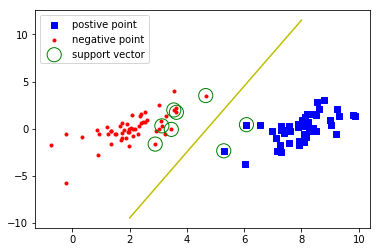

In [79]:
visualizeData(dataArr, labelArr, b, alphas)

## 完整版Platt SMO的支持函数
### Platt SMO支持函数

In [80]:
class optStructK:                                                                  #建立数据结构保存有效值，通过一个对象来完成
    def __init__(self,dataMatIn, classLabels, C, toler):
        '''
        :param dataMatIn: 数据集
        :param classLabels: 类别标签
        :param C: 参数C
        :param toler: 容错率(松弛变量)
        :param kTup: 核函数类型及其参数
        '''
        self.X = dataMatIn
        self.labelMat = classLabels
        self.C = C
        self.tol = toler
        self.m = np.shape(dataMatIn)[0]
        self.alphas = np.zeros((self.m,1))
        self.b = 0
        #误差缓存
        self.eCache = np.zeros((self.m,2))                                         #第一列为是否有效的标志位，第二列为实际E值
        self.K = mat(zeros((self.m,self.m)))

In [81]:
def calcEkK(oS, k):                                                                #对于给定alpha值，eCahe计算E值并返回
    fXk = np.float(np.dot((oS.alphas * oS.labelMat).T, np.dot(oS.X, oS.X[k,:].T))) + oS.b
    Ek = fXk - np.float(oS.labelMat[k])
    return Ek

In [82]:
#用于选择第二个alpha或者说内循环的alpha，内循环中的启发式方法
'''第二个参数依据更新跨度大小来选择，而由于ηη计算量较大，所以近似以|E2−E1||E2−E1|来衡量更新跨度，即在确定了第一个参数的情况下，选择第二个参数使得|E2−E1||E2−E1|最大。 
第二个参数的选择首先在非边界样本集上进行，若无法找到具有足够更新跨度的参数，则在整体样本集上找，若还是找不到则重新选择第一个参数。'''
def selectJK(i, oS, Ei):
    """
    内循环选择alpha的启发式算法
    参数：
        i -- 外循环alpha的下标
        oS -- 类
        Ei -- 误差
    返回：
        j -- 选择的alpha的下标
        Ej -- 误差
    """
    maxK = -1; maxDeltaE = 0; Ej = 0                                                      #初始化
    oS.eCache[i] = [1,Ei]                                                                 #选择合理的集合
    validEcacheList = np.nonzero(oS.eCache[:,0])[0]
    if (len(validEcacheList)) > 1:                                                        #选择最大步长的alpha
        for k in validEcacheList:
            if k == i: continue                                                           #不重复计算
            Ek = calcEkK(oS, k)                                                           #计算误差
            deltaE = abs(Ei - Ek)                                                         #计算步长
            if (deltaE > maxDeltaE):                                                      #记录最佳选择
                maxK = k; maxDeltaE = deltaE; Ej = Ek
        return maxK, Ej
    else:                                                                                 #如果没有合理值
        j = selectJrand(i, oS.m)                                                          #随机选择
        Ej = calcEkK(oS, j)
    return j, Ej

In [83]:
def updateEkK(oS, k):                                                                     #在alpha更新后存储计算得到的误差
    Ek = calcEkK(oS, k)
    oS.eCache[k] = [1,Ek]

### Platt SMO算法中的优化例程

In [84]:
def innerLK(i, oS):
    Ei = calcEkK(oS, i)                                                                                                                #计算误差
    if ((oS.labelMat[i, 0]*Ei < -oS.tol) and (oS.alphas[i, 0] < oS.C)) or ((oS.labelMat[i, 0]*Ei > oS.tol) and (oS.alphas[i, 0] > 0)): #找出不满足KKT条件的alpha
        j,Ej = selectJK(i, oS, Ei)                                                                                                     #选择j
        alphaIold = oS.alphas[i, 0].copy(); alphaJold = oS.alphas[j, 0].copy();                                                        #存储旧的值
        if (oS.labelMat[i, 0] != oS.labelMat[j, 0]):                                                                                   #两种情况求边界值
            L = max(0, oS.alphas[j, 0] - oS.alphas[i, 0])
            H = min(oS.C, oS.C + oS.alphas[j, 0] - oS.alphas[i, 0])
        else:
            L = max(0, oS.alphas[j, 0] + oS.alphas[i, 0] - oS.C)
            H = min(oS.C, oS.alphas[j, 0] + oS.alphas[i, 0])
        if L==H: return 0                                                                                                              #计算变化量
        eta = 2.0 * np.dot(oS.X[i:i+1,:], oS.X[j:j+1,:].T) - np.dot(oS.X[i:i+1,:], oS.X[i:i+1,:].T) - np.dot(oS.X[j:j+1,:], oS.X[j:j+1,:].T)
        if eta >= 0: return 0
        oS.alphas[j, 0] -= oS.labelMat[j, 0]*(Ei - Ej)/eta                                                                             #更新alpha
        oS.alphas[j, 0] = clipAlpha(oS.alphas[j, 0],H,L)                                                                               #约束alpha
        updateEkK(oS, j)
        if (abs(oS.alphas[j, 0] - alphaJold) < 0.00001): return 0
        oS.alphas[i, 0] += oS.labelMat[j, 0]*oS.labelMat[i, 0]*(alphaJold - oS.alphas[j, 0])
        updateEkK(oS, i)
        b1 = oS.b - Ei- oS.labelMat[i, 0]*(oS.alphas[i, 0]-alphaIold)*np.dot(oS.X[i:i+1,:], oS.X[i:i+1,:].T) - oS.labelMat[j, 0]*(oS.alphas[j, 0]-alphaJold)*np.dot(oS.X[i:i+1,:], oS.X[j:j+1,:].T)
        b2 = oS.b - Ej- oS.labelMat[i, 0]*(oS.alphas[i, 0]-alphaIold)*np.dot(oS.X[i:i+1,:], oS.X[j:j+1,:].T) - oS.labelMat[j, 0]*(oS.alphas[j, 0]-alphaJold)*np.dot(oS.X[j:j+1,:], oS.X[j:j+1,:].T)
        if (0 < oS.alphas[i, 0]) and (oS.C > oS.alphas[i, 0]): oS.b = b1
        elif (0 < oS.alphas[j, 0]) and (oS.C > oS.alphas[j, 0]): oS.b = b2
        else: oS.b = (b1 + b2)/2.0
        return 1
    else: return 0

### Platt SMO算法外循环代码

In [100]:
def smoPK(dataMatIn, classLabels, C, toler, maxIter):                                                                                
    oS = optStructK(np.array(dataMatIn),np.array(classLabels).reshape(-1, 1),C,toler)                                                #建立类变量
    iter = 0
    entireSet = True; alphaPairsChanged = 0                                                                                          #执行循环                                       
    while (iter < maxIter) and ((alphaPairsChanged > 0) or (entireSet)):
        alphaPairsChanged = 0
        if entireSet:                                                                                                                #遍历所有
            for i in range(oS.m):        
                alphaPairsChanged += innerLK(i,oS)
                #print("fullSet, iter: {} i:{}, pairs changed {}".format(iter,i,alphaPairsChanged))
            iter += 1
        else:                                                                                                                       #遍历非边界值
            nonBoundIs = np.nonzero((oS.alphas > 0) * (oS.alphas < C))[0]
            for i in nonBoundIs:
                alphaPairsChanged += innerLK(i,oS)
                #print("non-bound, iter: {} i:{}, pairs changed {}".format(iter,i,alphaPairsChanged))
            iter += 1
        if entireSet: entireSet = False 
        elif (alphaPairsChanged == 0): entireSet = True  
        #print("iteration number: {}".format(iter))
    return oS.b,oS.alphas

In [88]:
dataArr, labelArr = loadDataSet("C:/Users/Administrator/testSet.txt")
b, alphas = smoPK(dataArr, labelArr, 0.6, 0.001, 40)
print("b = {}\nalphas[alphas > 0] = {}".format(b, alphas[alphas > 0]))

b = [[-3.29377054]]
alphas[alphas > 0] = [0.10457871 0.00889974 0.00949033 0.01283887 0.01283887 0.11347845
 0.11704003 0.11704003 0.00949033]


In [89]:
def calcWs(alphas,dataArr,classLabels):                              # 计算 w*x + b 中的 w
    X = mat(dataArr)
    labelMat = mat(classLabels).transpose()
    m,n = shape(X)                                                   # m个样本，n个特征
    w = zeros((n,1))                                                 # W为n行1列，X*W = L.T
    for i in range(m):
        w += multiply(alphas[i]*labelMat[i],X[i,:].T)                # w = ∑ alpha_i * xi * yi
    return w

In [91]:
ws=calcWs(alphas,dataArr,labelArr)
ws

array([[ 0.72778293],
       [-0.31408713]])

## 在测试中使用核函数

In [115]:
def kernelTrans(X, A, kTup):                                                    #calc the kernel or transform data to a higher dimensional space
    m,n = shape(X)
    K = mat(zeros((m,1)))
    if kTup[0]=='lin': K = X * A.T                                              #linear kernel
    elif kTup[0]=='rbf':
        for j in range(m):
            deltaRow = X[j,:] - A
            K[j] = deltaRow*deltaRow.T
        K = exp(K/(-1*kTup[1]**2))                                              #divide in NumPy is element-wise not matrix like Matlab
    else: raise NameError('Houston We Have a Problem -- \
    That Kernel is not recognized')
    return K

In [116]:
class optStruct:
    def __init__(self,dataMatIn, classLabels, C, toler, kTup):  # Initialize the structure with the parameters 
        self.X = dataMatIn
        self.labelMat = classLabels
        self.C = C
        self.tol = toler
        self.m = shape(dataMatIn)[0]
        self.alphas = mat(zeros((self.m,1)))
        self.b = 0
        self.eCache = mat(zeros((self.m,2))) #first column is valid flag
        self.K = mat(zeros((self.m,self.m)))
        for i in range(self.m):
            self.K[:,i] = kernelTrans(self.X, self.X[i,:], kTup)

In [117]:
#使用核函数时需要对以上函数进行修改：
def selectJ(i, oS, Ei):         #this is the second choice -heurstic, and calcs Ej
    maxK = -1; maxDeltaE = 0; Ej = 0
    oS.eCache[i] = [1,Ei]                                                      #set valid #choose the alpha that gives the maximum delta E
    validEcacheList = nonzero(oS.eCache[:,0].A)[0]
    if (len(validEcacheList)) > 1:
        for k in validEcacheList:                                              #loop through valid Ecache values and find the one that maximizes delta E
            if k == i: continue                                                #don't calc for i, waste of time
            Ek = calcEk(oS, k)
            deltaE = abs(Ei - Ek)
            if (deltaE > maxDeltaE):
                maxK = k; maxDeltaE = deltaE; Ej = Ek
        return maxK, Ej
    else:                                                                      #in this case (first time around) we don't have any valid eCache values
        j = selectJrand(i, oS.m)
        Ej = calcEk(oS, j)
    return j, Ej
def innerL(i, oS):
    Ei = calcEk(oS, i)
    if ((oS.labelMat[i]*Ei < -oS.tol) and (oS.alphas[i] < oS.C)) or ((oS.labelMat[i]*Ei > oS.tol) and (oS.alphas[i] > 0)):
        j,Ej = selectJ(i, oS, Ei)                                                                      #this has been changed from selectJrand
        alphaIold = oS.alphas[i].copy(); alphaJold = oS.alphas[j].copy();
        if (oS.labelMat[i] != oS.labelMat[j]):
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if L==H: print("L==H"); return 0
        eta = 2.0 * oS.K[i,j] - oS.K[i,i] - oS.K[j,j]                                                       #changed for kernel
        if eta >= 0: print("eta>=0"); return 0
        oS.alphas[j] -= oS.labelMat[j]*(Ei - Ej)/eta
        oS.alphas[j] = clipAlpha(oS.alphas[j],H,L)
        updateEk(oS, j) #added this for the Ecache
        if (abs(oS.alphas[j] - alphaJold) < 0.00001): print("j not moving enough"); return 0
        oS.alphas[i] += oS.labelMat[j]*oS.labelMat[i]*(alphaJold - oS.alphas[j])                           #update i by the same amount as j
        updateEk(oS, i)                                                                                   #added this for the Ecache                    #the update is in the oppostie direction
        b1 = oS.b - Ei- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i,i] - oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.K[i,j]
        b2 = oS.b - Ej- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i,j]- oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.K[j,j]
        if (0 < oS.alphas[i]) and (oS.C > oS.alphas[i]): oS.b = b1
        elif (0 < oS.alphas[j]) and (oS.C > oS.alphas[j]): oS.b = b2
        else: oS.b = (b1 + b2)/2.0
        return 1
    else: return 0
# <editor-fold desc="更新误差缓存">
def updateEk(oS, k):#after any alpha has changed update the new value in the cache 当alpha_k的值改变，对应的Ek误差值也变
    Ek = calcEk(oS, k)
    oS.eCache[k] = [1,Ek]
# </editor-fold>
def calcEk(oS, k):
    fXk = float(multiply(oS.alphas,oS.labelMat).T*oS.K[:,k] + oS.b)
    Ek = fXk - float(oS.labelMat[k])
    return Ek
def smoP(dataMatIn, classLabels, C, toler, maxIter,kTup=('lin', 0)):    #full Platt SMO
    oS = optStruct(mat(dataMatIn),mat(classLabels).transpose(),C,toler, kTup)
    iter = 0
    entireSet = True; alphaPairsChanged = 0
    while (iter < maxIter) and ((alphaPairsChanged > 0) or (entireSet)):
        alphaPairsChanged = 0
        if entireSet:   #go over all
            for i in range(oS.m):        
                alphaPairsChanged += innerL(i,oS)
                print("fullSet, iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged))
            iter += 1
        else:#go over non-bound (railed) alphas
            nonBoundIs = nonzero((oS.alphas.A > 0) * (oS.alphas.A < C))[0]
            for i in nonBoundIs:
                alphaPairsChanged += innerL(i,oS)
                print("non-bound, iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged))
            iter += 1
        if entireSet: entireSet = False #toggle entire set loop
        elif (alphaPairsChanged == 0): entireSet = True  
        print("iteration number: %d" % iter)
    return oS.b,oS.alphas

In [118]:
def testRbf(k1=1.3):
    dataArr,labelArr = loadDataSet('C:/Users/Administrator/testSetRBF.txt')
    b,alphas = smoP(dataArr, labelArr, 200, 0.0001, 10000, ('rbf', k1)) #C=200 important
    datMat=mat(dataArr); labelMat = mat(labelArr).transpose()
    svInd=nonzero(alphas.A>0)[0]
    sVs=datMat[svInd] #get matrix of only support vectors
    labelSV = labelMat[svInd];
    print( "there are %d Support Vectors" % shape(sVs)[0])
    m,n = shape(datMat)
    errorCount = 0
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],('rbf', k1))
        predict=kernelEval.T * multiply(labelSV,alphas[svInd]) + b
        if sign(predict)!=sign(labelArr[i]): errorCount += 1
    print( "the training error rate is: %f" % (float(errorCount)/m))
    dataArr,labelArr = loadDataSet('C:/Users/Administrator/testSetRBF2.txt')
    errorCount = 0
    datMat=mat(dataArr); labelMat = mat(labelArr).transpose()
    m,n = shape(datMat)
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],('rbf', k1))
        predict=kernelEval.T * multiply(labelSV,alphas[svInd]) + b
        if sign(predict)!=sign(labelArr[i]): errorCount += 1    
    print( "the test error rate is: %f" % (float(errorCount)/m) )

In [ ]:
testRbf()

## 示例：基于SVM的手写数字识别

In [136]:
def img2vector(filename):
    returnVect = np.zeros((1,1024))
    fr = open(filename)
    for i in range(32):
        lineStr = fr.readline()
        for j in range(32):
            returnVect[0,32*i+j] = np.int(lineStr[j])
    return returnVect
def loadImages(dirName):
    from os import listdir
    hwLabels = []
    trainingFileList = listdir(dirName)           #load the training set
    m = len(trainingFileList)
    trainingMat = np.zeros((m,1024))
    for i in range(m):
        fileNameStr = trainingFileList[i]
        fileStr = fileNameStr.split('.')[0]     #take off .txt
        classNumStr = np.int(fileStr.split('_')[0])
        if classNumStr == 9: hwLabels.append(-1)
        else: hwLabels.append(1)
        trainingMat[i,:] = img2vector('%s/%s' % (dirName, fileNameStr))
    return trainingMat, hwLabels 

In [137]:
def testDigits(kTup=('rbf', 10)):
    dataArr,labelArr = loadImages('C:/Users/Administrator/digits/trainingDigits')
    b,alphas = smoP(dataArr, labelArr, 200, 0.0001, 10000, kTup)
    datMat=mat(dataArr); labelMat = mat(labelArr).transpose()
    svInd=nonzero(alphas.A>0)[0]
    sVs=datMat[svInd] 
    labelSV = labelMat[svInd];
    print ("there are %d Support Vectors" % shape(sVs)[0])
    m,n = shape(datMat)
    errorCount = 0
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],kTup)
        predict=kernelEval.T * multiply(labelSV,alphas[svInd]) + b
        if sign(predict)!=sign(labelArr[i]): errorCount += 1
    print ("the training error rate is: %f" % (float(errorCount)/m))
    dataArr,labelArr = loadImages('C:/Users/Administrator/digits/testDigits')
    errorCount = 0
    datMat=mat(dataArr); labelMat = mat(labelArr).transpose()
    m,n = shape(datMat)
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],kTup)
        predict=kernelEval.T * multiply(labelSV,alphas[svInd]) + b
        if sign(predict)!=sign(labelArr[i]): errorCount += 1    
    print ("the test error rate is: %f" % (float(errorCount)/m) )

In [ ]:
testDigits(('rbf', 5))     ##输入内核及σ值